<a href="https://colab.research.google.com/github/pbpbpb2705/ImageSegmentation-PyTorch/blob/main/ImageSegmentation_Completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-1icinrp3
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-1icinrp3
  Resolved https://github.com/albumentations-team/albumentations to commit c70e664e060bfd7463c20674927aed217f72d437
  Preparing metadata (setup.py) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


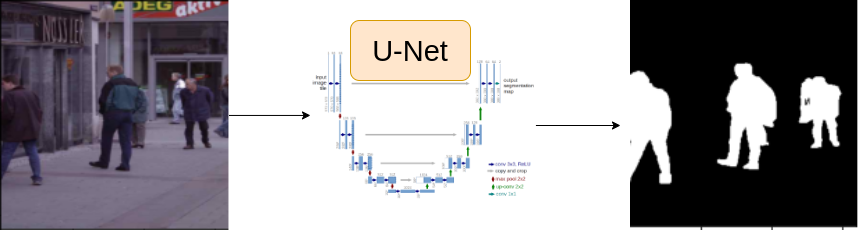

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
csv_file = '/content/Human-Segmentation-Dataset-master/train.csv'
data_dir = '/content/'

device = 'cuda'

epoch = 30
learning_rate = 0.003
image_size = 320
batch_size = 8

encoder = 'timm-efficientnet-b0'
weights = 'imagenet'


In [ ]:
df = pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
#Read a sample image from dataset
row = df.iloc[68]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
print(image.shape)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0
print(mask.shape)

(480, 640, 3)
(433, 577)


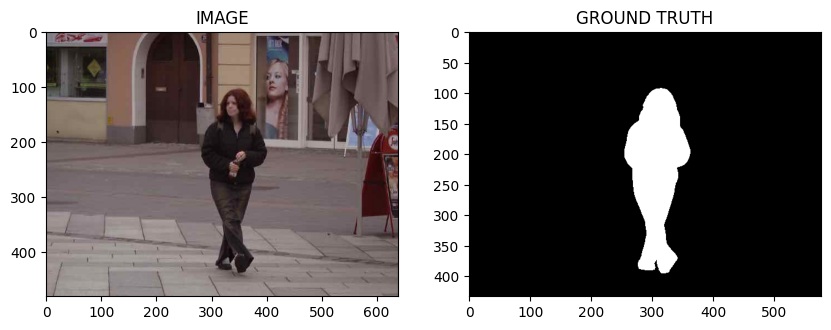

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_set, valid_set = train_test_split(df, test_size=0.25, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
#Augmentation step (Rotation, Flips, Resize)
def get_train_augmentations():
  return A.Compose([
    A.Resize(image_size, image_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
  ], is_check_shapes = False)

def get_valid_augmentations():
  return A.Compose([
    A.Resize(image_size, image_size),
  ], is_check_shapes = False)

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    # Get row from df
    row = self.df.iloc[idx]

    # Get filepath
    image_path = row.images
    mask_path = row.masks

    # Read the image from file
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(image_path, mask_path)

    # Read the mask from file
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w)
    mask = np.expand_dims(mask, axis=-1) #(h, w, 1)

    # If augmentations exist => apply augmentation
    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image, mask = data['image'], data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask


In [ ]:
trainset = SegmentationDataset(train_set, get_train_augmentations())
validset = SegmentationDataset(valid_set, get_valid_augmentations())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 217
Size of Validset : 73


Human-Segmentation-Dataset-master/Training_Images/160.jpg Human-Segmentation-Dataset-master/Ground_Truth/160.png


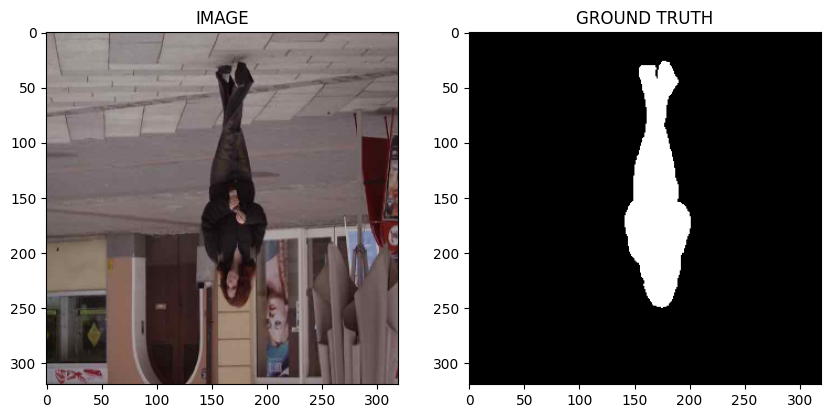

In [ ]:
idx = 0

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size)

In [ ]:
print(f"Size of Trainloader : {len(trainloader)}")
print(f"Size of Validloader : {len(validloader)}")

Size of Trainloader : 28
Size of Validloader : 10


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = 'timm-efficientnet-b0',
        encoder_weights = 'imagenet',
        in_channels = 3,
        classes = 1,
        activation = None,
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      dice_loss = DiceLoss(mode='binary')(logits, masks)
      sigmoid_entropy_loss = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, dice_loss + sigmoid_entropy_loss

    return logits

In [ ]:
model = SegmentationModel()
model.to(device)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [ ]:
def train_func(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in data_loader:
    #Get images and masks from dataloader to calculate loss
    images = images.to(device)
    masks = masks.to(device)

    #Enable zero gradient
    optimizer.zero_grad()

    #Forward the instance to model
    logits, loss = model(images, masks)

    #Update loss and optimizer
    loss.backward()
    optimizer.step()

    #Update total loss
    total_loss += loss.item()

  #Return unweighted loss average
  return total_loss / len(data_loader)

In [ ]:
def eval_func(data_loader, model):

  model.train()
  total_loss = 0.0

  for images, masks in data_loader:
    #Get images and masks from dataloader to calculate loss
    images = images.to(device)
    masks = masks.to(device)

    #Forward the instance to model
    logits, loss = model(images, masks)

    #Update total loss
    total_loss += loss.item()

  #Return unweighted loss average
  return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [ ]:
lowest_valid_loss = np.Inf

for i in range(epoch):
  train_loss = train_func(trainloader, model, optimizer)
  valid_loss = eval_func(validloader, model)

  if valid_loss < lowest_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('Saved checkpoint')
    lowest_valid_loss = valid_loss

  print(f'Epoch : {i+1}/{epoch}, Train Loss : {train_loss}, Valid Loss : {valid_loss}')

Human-Segmentation-Dataset-master/Training_Images/44.jpg Human-Segmentation-Dataset-master/Ground_Truth/44.png
Human-Segmentation-Dataset-master/Training_Images/124.jpg Human-Segmentation-Dataset-master/Ground_Truth/124.png
Human-Segmentation-Dataset-master/Training_Images/236.jpg Human-Segmentation-Dataset-master/Ground_Truth/236.png
Human-Segmentation-Dataset-master/Training_Images/222.jpg Human-Segmentation-Dataset-master/Ground_Truth/222.png
Human-Segmentation-Dataset-master/Training_Images/105.jpg Human-Segmentation-Dataset-master/Ground_Truth/105.png
Human-Segmentation-Dataset-master/Training_Images/136.jpg Human-Segmentation-Dataset-master/Ground_Truth/136.png
Human-Segmentation-Dataset-master/Training_Images/219.jpg Human-Segmentation-Dataset-master/Ground_Truth/219.png
Human-Segmentation-Dataset-master/Training_Images/113.jpg Human-Segmentation-Dataset-master/Ground_Truth/113.png
Human-Segmentation-Dataset-master/Training_Images/12.jpg Human-Segmentation-Dataset-master/Ground_

# Task 9 : Inference

In [ ]:
idx = 10

model.load_state_dict(torch.load('best_model.pt'))

image, mask = valid_set[idx]

logits_mask = model(image.to(device).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)

pred_mask = (pred_mask > 0.5)*1.0

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))